# 本页代码用于求出不同组水质数据的Koopman算子及其特征值，并以此构建其衡量指标

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 获取数据

In [2]:
data = np.load('./databygroup.npy',allow_pickle=True).tolist()
TrainData,TestData={},{}
for k in data.keys():
    if '.csv0' in k:
        TrainData[k]=data[k]
    else:
        TestData[k]=data[k]

In [8]:
#Tdata=TrainData[TrainData.keys()]
xtrain,ytrain=[],[]
for k in TrainData.keys():
    for i in range(int(TrainData[k].shape[0])):
        xtrain.append(TrainData[k][i,1:TrainData[k].shape[1]-4].tolist())
        ytrain.append(TrainData[k][i,[-4,-3,-2,-1]].tolist())
    #xtrain.append(xtem)
    #ytrain.append(ytem)

In [9]:
for k in TestData.keys():
    if os.path.exists('./DLEDMD_model/'+k):
        pass
    else:
        os.makedirs('./DLEDMD_model/'+k)

if os.path.exists('./DLEDMD_model/traindata'):
    pass
else:
    os.makedirs('./DLEDMD_model/traindata')

for d in TestData.keys():
    if not os.path.exists('./results/'+d):
        if '.csv0' not in d:
            os.makedirs('./results/'+d)
if not os.path.exists('./results/traindata'):
    os.makedirs('./results/traindata')

# 动力系统相关

In [4]:
import math
import scipy.linalg as linalg
from scipy.spatial.distance import pdist, cdist

In [5]:
#matrix decomposition tools
# return U,s,V   A=U*diag(s)*V'
def truncated_svd(A,m=np.inf):
    m=min((m,)+A.shape)
    U,s,Vh=linalg.svd(A)
    tol=max(A.shape)*np.spacing(s[0])
    m=min(m,np.count_nonzero(s>tol))
    return U[:,:m],s[:m],Vh[:m].T

# return U,s   A=U*diag(s)*U'
def truncated_svd_sym(A,m=np.inf):
    m=min(m,A.shape[0])
    S,U=linalg.schur(A)
    s=np.diag(S)
    abs_s=np.absolute(s)
    tol=A.shape[0]*np.spacing(abs_s.max())
    m=min(m,np.count_nonzero(abs_s>tol))
    idx=(-abs_s).argsort()[:m]
    return U[:,idx],s[idx]

# return U,s   A=U*diag(s)*U'
def truncated_svd_psd(A,m=np.inf,eps=0):
    m=min(m,A.shape[0])
    S,U=linalg.schur(A)
    s=np.diag(S)
    tol=A.shape[0]*np.spacing(np.absolute(s).max())
    mi=s.min()
    if mi<0 and -mi>tol:
        tol=-mi
    tol = np.maximum(tol, np.absolute(s).max()*eps)
    m=min(m,np.count_nonzero(s>tol))
    idx=(-s).argsort()[:m]
    return U[:,idx],s[idx]

# return R   A=R*R'
def cholcov(A,m=np.inf):
    U,s=truncated_svd_psd(A,m)
    return U*np.sqrt(s)

# return pinv(R)   A=R*R'
def pinv_cholcov(A,m=np.inf,eps=0):
    U,s=truncated_svd_psd(A,m)
    tol=np.absolute(s).max()*eps
    mm=min(m,np.count_nonzero(s>tol))
    return (U[:,:mm]*(1.0/np.sqrt(s[:mm]))).T

# The new observable is U'*f
def truncated_eig(K, m=np.inf, return_reconstruct_K=False):
    m = min(m, K.shape[0])
    w, Q = linalg.eig(K) # K = Q.dot(w).dot(linalg.inv(Q))
    idx = np.argsort(np.abs(w))[::-1]
    w = w[idx]
    Q = Q[:, idx]
    iQ = linalg.inv(Q)
    K_hat = (Q[:, :m] * w[:m]).dot(iQ[:m, :])
    if not np.allclose(np.real(K_hat), K_hat):
        for n in range(m + 1, K.shape[0] + 1):
            K_hat = (Q[:, :n] * w[:n]).dot(iQ[:n])
            if np.allclose(np.real(K_hat), K_hat):
                break
    K_hat = np.real(K_hat)
    U, s, V = truncated_svd(K_hat)
    #print(linalg.norm(K_hat - (U*s).dot(V.T)))
    K_new = (U.T.dot(V * s)).T
    if return_reconstruct_K:
        return K_new, U, K_hat
    return K_new, U

def gramian_function(X, Y=None):
    if Y is None:
        return np.exp(-(cdist(X, X) / 1.5)**2)
    else:
        return np.exp(-(cdist(X, Y) / 1.5)**2)

In [6]:
class linear_edmd():
    
    def __init__(self, input_dim, feature_mapping):
        '''
        :input_dim: dimension of data
        :feature mapping: A function from (N * input_dim) array to (N * feature_dim) array
        '''
        self.input_dim = input_dim
        self.feature_mapping = feature_mapping
    
    def whiten(self, X, eps=0, return_whitened_data=False):
        #whitening transformation: (Chi-self.whiten_mean).dot(self.whiten_T.T)
        Chi = self.feature_mapping(X)
        m = np.mean(Chi, axis=0)
        C = (Chi - m).T.dot(Chi - m)/X.shape[0]
        T = pinv_cholcov(C, eps=eps)
        self.whiten_mean = m
        self.whiten_T = T
        self.feature_dim = T.shape[1]
        if return_whitened_data:
            return np.hstack([np.ones([Chi.shape[0], 1]), (Chi - m).dot(T.T)])
    
    def whitened_feature_mapping(self, X):
        return np.hstack([np.ones([X.shape[0], 1]), (self.feature_mapping(X)-self.whiten_mean).dot(self.whiten_T.T)])
    
    def train(self, X, Y, eps=0.):
        N = X.shape[0]
        self.X_train = X.copy()
        self.Y_train = Y.copy()        
        Chi_0 = self.whiten(X, eps=eps, return_whitened_data=True)
        Chi_1 = self.whitened_feature_mapping(Y)
        self.K = Chi_0.T.dot(Chi_1) / N
    
    def prediction(self, x0, T, obs_mapping=None, nontrivial_mode_num=np.inf, return_std=False):
        """
        Predict the mean value of the trajectory of the observable from time 1 to time T with x(0)=x0
        :x0: start point
        :T: trajectory length
        :obs_mapping: The observable function from (N * input_dim) array to (N * ...) array. If None, it is identity mapping
        :nontrivial_mode_num: Number of non-trivial singular functions
        :return_std: If return estimated std
        :return: Trajectory of the observable, or (traj, traj_std)
        """
        N = self.Y_train.shape[0]
        m = min(nontrivial_mode_num + 1, self.K.shape[0])
        K, U = truncated_eig(self.K, m)
        m = K.shape[0]
        
        Chi_0 = self.whitened_feature_mapping(self.X_train).dot(U)
        
        if obs_mapping is None:
            O = self.Y_train
        else:
            O = obs_mapping(self.Y_train)
        if return_std:
            O = np.hstack([O, O ** 2])
        
        G = Chi_0.T.dot(O) / N
        
        f0 = self.whitened_feature_mapping(x0.reshape(1, -1)).dot(U).T

        traj = np.empty([T, O.shape[1]])
        for t in range(T):
            traj[t] = (G.T.dot(np.linalg.matrix_power(K.T, t))).dot(f0).reshape(-1)
        if return_std:
            traj_std = np.sqrt(np.maximum(traj[:, (int)(traj.shape[1]/2):] - traj[:, :(int)(traj.shape[1]/2)] ** 2, 0))
            return traj[:, :(int)(traj.shape[1]/2)], traj_std
        return traj

def feature_mapping(X):
    return X

In [18]:
X = np.array(xtrain)[0:-2,1:].astype(np.float64)
Y = np.array(xtrain)[1:-1,1:].astype(np.float64)
print(X.shape)

model_mmd_dmd = linear_edmd(input_dim=X.shape[1], feature_mapping=feature_mapping)
model_mmd_dmd.train(X, Y)
U,s,V=np.linalg.svd(model_mmd_dmd.K)
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step2_Koopman')
np.save('./results/traindata/U.npy',U)
np.save('./results/traindata/V.npy',V)
np.save('./results/traindata/s.npy',s)
os.chdir(os.path.pardir)
print(os.getcwd())
np.save('./Step4_Compare/results_s/traindata/U.npy',U)
np.save('./Step4_Compare/results_s/traindata/V.npy',V)
np.save('./Step4_Compare/results_s/traindata/s.npy',s)
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step2_Koopman')

(603, 63)
/Users/tianwenchong/Desktop/Text12-Koopman-WQ


In [10]:
ss={}
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step2_Koopman')
for d in TestData.keys():
    if '.csv0' not in d:
        X = TestData[d][0:-2,1:].astype(np.float64)
        Y = TestData[d][1:-1,1:].astype(np.float64)

        model_mmd_dmd = linear_edmd(input_dim=X.shape[1], feature_mapping=feature_mapping)
        model_mmd_dmd.train(X, Y)
        U,s,V=np.linalg.svd(model_mmd_dmd.K)
        np.save('./results/'+d+'/U.npy',U)
        np.save('./results/'+d+'/V.npy',V)
        np.save('./results/'+d+'/s.npy',s)
        #s,U=np.linalg.eig(model_mmd_dmd.K)
        np.save('./results/'+d+'/U.npy',U)
        np.save('./results/'+d+'/s.npy',s)
        ss[d]=s
        os.chdir(os.path.pardir)
        print(os.getcwd())
        np.save('./Step4_Compare/results_s/'+k+'/U.npy',U)
        np.save('./Step4_Compare/results_s/'+k+'/V.npy',V)
        np.save('./Step4_Compare/results_s/'+k+'/s.npy',s)
        os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step2_Koopman')

/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12-Koopman-WQ
/Users/tianwenchong/Desktop/Text12

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

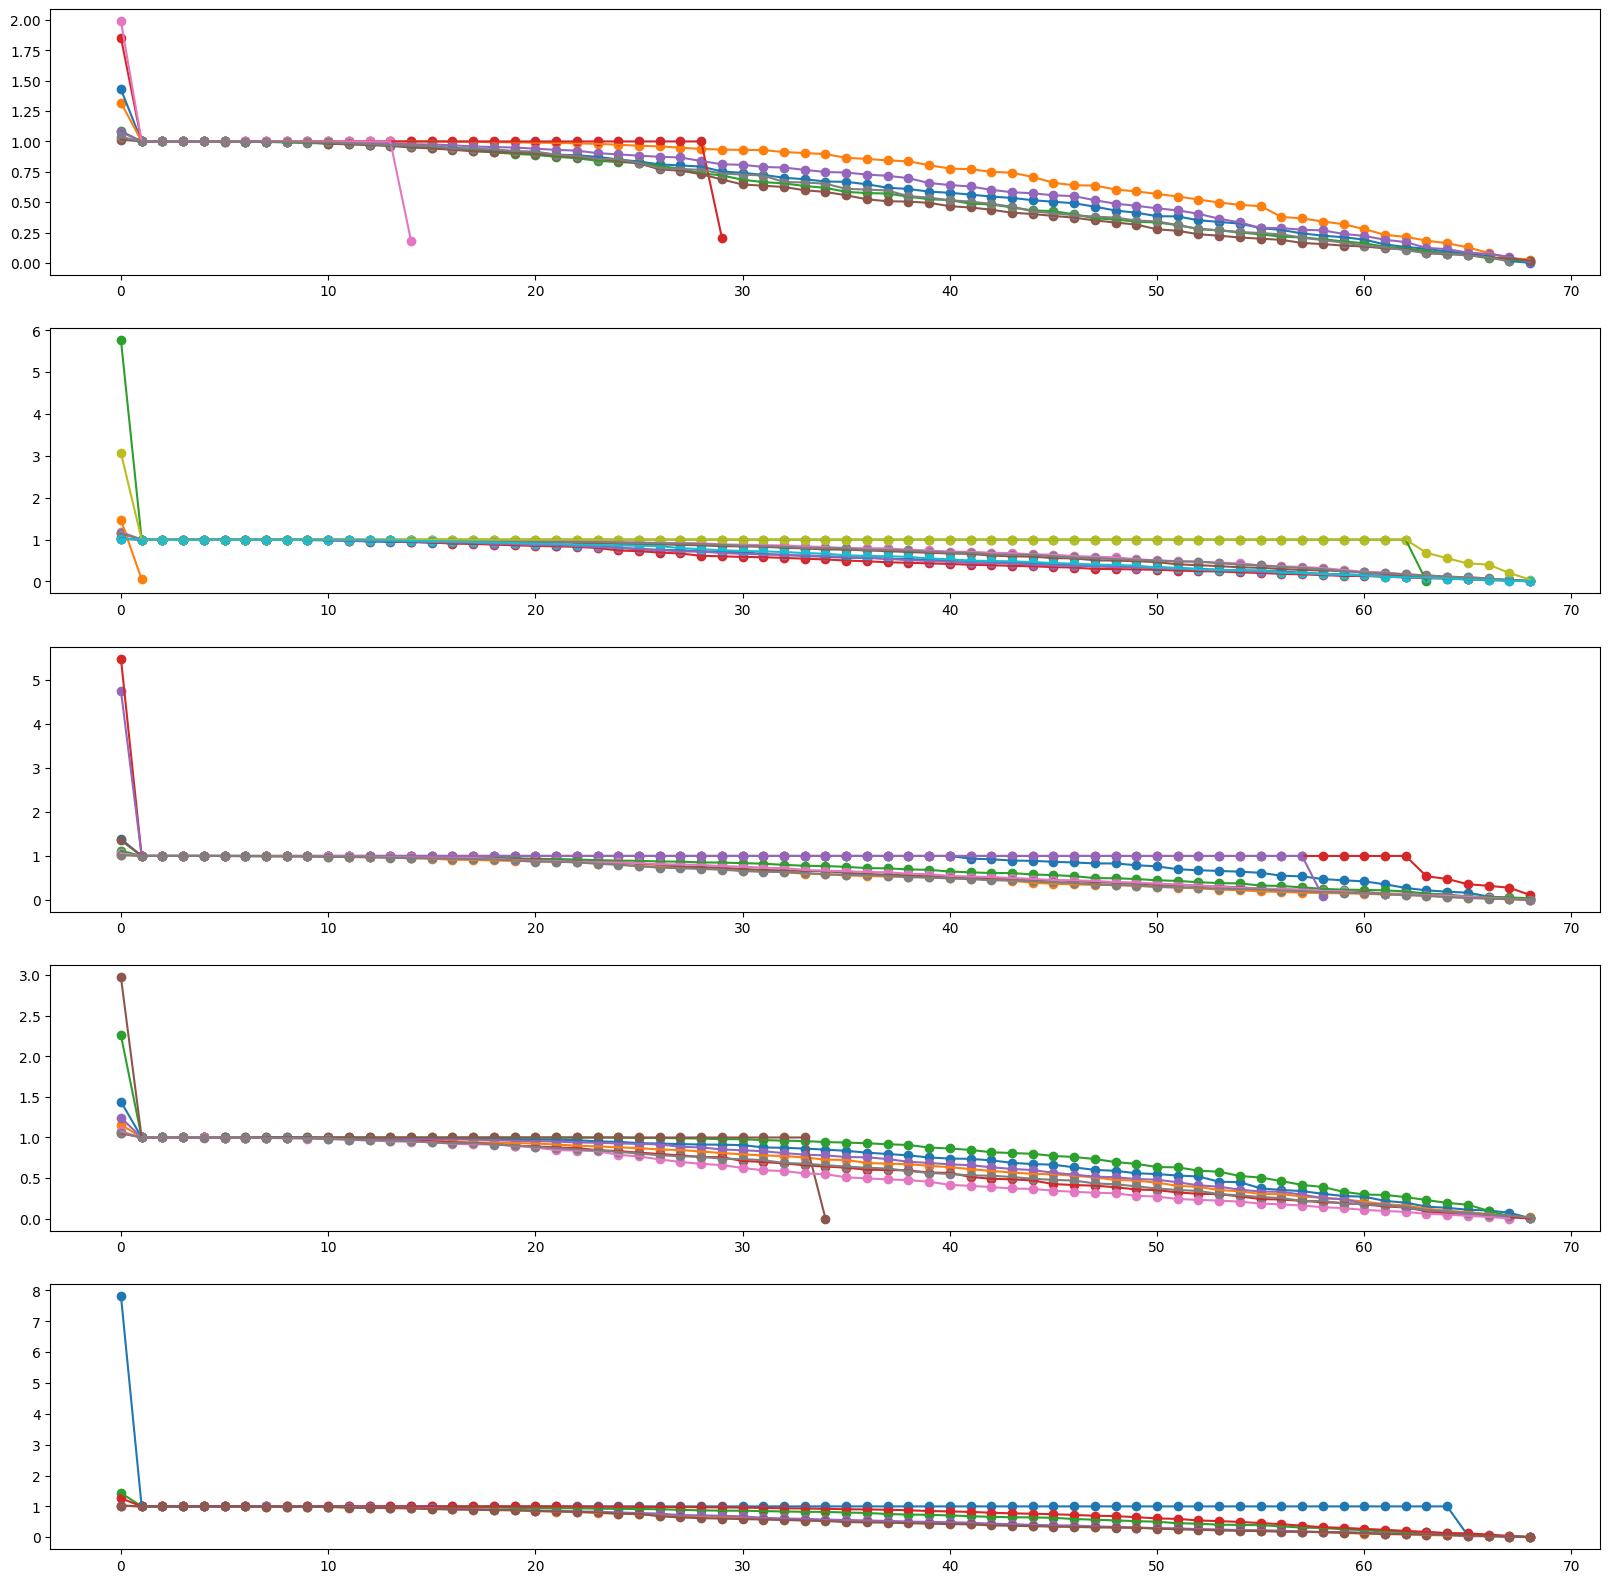

In [11]:
font1 = {'weight' : 'normal',
         'size'   : 20,}

fig,ax=plt.subplots(5,1,figsize=(20,20))
for d in ss.keys():
    if '56' in d:
        figline=0
    elif '75' in d:
        figline=1
    elif '80' in d:
        figline=2
    elif '114' in d:
        figline=3
    elif '118' in d:
        figline=4
    
    ax[figline].plot(np.abs(ss[d]))
    ax[figline].scatter([i for i in range(ss[d].shape[0])],np.abs(ss[d]))
    
    '''
    eig_data=[]
    for ei in ss[d]:
        eig_data.append([np.real(ei),np.imag(ei)])
    eig_data=np.array(eig_data)
    ax[figline].scatter(eig_data[:,0],eig_data[:,1])
    
    ax[figline].axhline(y=0,ls=":",c="grey")#添加水平直线
    ax[figline].axvline(x=0,ls=":",c="grey")#添加水平直线
    theta = np.linspace(0, 2 * np.pi, 200)
    x = np.cos(theta)
    y = np.sin(theta)
    ax[figline].plot(x, y, color="darkred", linewidth=1,linestyle=':')
    '''